<a href="https://colab.research.google.com/github/abstractguy/lstm_autoencoder_classifier/blob/master/LSTM_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset: LSTM Autoencoder for Rare Event Binary Classification in Multivariate Time Series**

https://arxiv.org/abs/1809.10717 (please cite this article, if using the dataset).

https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098

https://github.com/cran2367/autoencoder_classifier/blob/master/autoencoder_classifier.ipynb

In [0]:
# Money maker by Samuel Duclos.
AI = 'LSTM_autoencoder'

In [0]:
# Hardcode parameters.
if AI == 'LSTM':
    main_ticker = 'AAPL'
    batch_size = 64
    epochs = 100
    learning_rate = 0.000003
    test_size = 0.2
    lookback = 5 # Days of past data.
    tickers_list = []

elif AI == 'LSTM_autoencoder':
    main_ticker = 'FB'
    batch_size = 64
    epochs = 200
    learning_rate = 0.00008
    random_seed = 123
    test_size = 0.2
    lookback = 5 # Days of past data.
    gain = 0.065 # Percentage of gain to consider good for trade.
    tickers_list = ['GE', 
                    'ADS', 
                    'INTC', 
                    'AAPL', 
                    'NVDA', 
                    'CSCO', 
                    'AMD', 
                    'AMZN', 
                    'GOOG', 
                    'MSFT', 
                    'S', 
                    'BAC', 
                    'XLNX', 
                    'WFC', 
                    '^DJI', 
                    '^GSPC', 
                    '^NYA', 
                    '^IXIC']

In [3]:
%matplotlib inline

from math import sqrt
from os import chdir
from os.path import exists
from datetime import datetime
from tqdm import tqdm
from numpy.random import seed
from numpy import append, array, concatenate, count_nonzero, empty, empty_like, expand_dims, mean, nan, power, var, where, zeros
from pandas import concat, DataFrame, date_range, read_csv, Series
from pandas_datareader.data import DataReader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import auc, classification_report, confusion_matrix, f1_score, mean_squared_error, precision_recall_curve, precision_recall_fscore_support, recall_score, roc_curve
from tensorflow import set_random_seed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import optimizers, Sequential
from google.colab.drive import mount
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from seaborn import heatmap

import matplotlib.pyplot as plt

seed(7)
set_random_seed(11)
labels = ['Normal', 'Break']

Using TensorFlow backend.


In [0]:
path = '/content/gdrive/'
mount(path)
path = path + 'My Drive/LSTM_autoencoder/'
chdir(path)

In [0]:
def add_ticker_to_tickers(symbol, ticker, tickers):
    if symbol not in tickers.columns:
        tickers = tickers[tickers.index >= ticker.index.min()]
        tickers = concat([tickers, ticker.to_frame(name=symbol)], axis='columns', join='inner')

    return tickers

def download_ticker_from_yahoo(symbol, start=None, end=None):
    if start is None or end is None:
        start = datetime(1970, 1, 1)
        end = datetime.now()

    return DataReader(symbol, 'yahoo', start=start, end=end)

def get_stock(main_ticker, tickers_list, path=path):
    csv_path = path + 'dataset.csv'

    if exists(csv_path):
        tickers = read_csv(csv_path)
    else:
        start = datetime(1970, 1, 1)
        end = datetime.now()
        tickers = DataReader(main_ticker, 'yahoo', start=start, end=end).High.dropna().to_frame(name=main_ticker)
        tickers.index.name = 'Date'

        for symbol in tqdm(tickers_list, unit='symbol'):
            try:
                ticker = download_ticker_from_yahoo(symbol, start=start, end=end)
                tickers = add_ticker_to_tickers(symbol, ticker.High, tickers)

            except:
                pass

        business_days = (~tickers.dropna().asfreq('D').isna().any(axis='columns')).astype(int)

        ticker = DataReader(main_ticker, 'yahoo', start=start, end=end)
        ticker_y = ticker.Close / ticker.Open
        #ticker_y = ticker.High
        tickers = add_ticker_to_tickers(main_ticker + '_y', ticker_y, tickers)

        tickers = tickers.asfreq('D').fillna(method='backfill')
        tickers = add_ticker_to_tickers('Business_days', business_days, tickers)

        tickers.to_csv(csv_path)

    return tickers

def extract_column(dataset, column_name):
    extracted = dataset[column_name].copy()
    dataset = dataset.drop(columns=[column_name])
    return dataset, extracted

def delta_time_series(data):
    data = data.astype('float32').values
    return data[1:] - data[:-1]

def delta_time_series_df(data):
    data = data.astype('float32')
    data = data - data.shift(periods=-1, fill_value=0.0, axis='index')
    data.iloc[-1] = 0.0
    return data

def delta_time_ratios_df(data):
    data = data.astype('float32')
    data = data / data.shift(periods=-1, fill_value=1.0, axis='index')
    data.iloc[-1] = 1.0
    return data

def plot_dataset(dataset):
    plt.plot(dataset)
    plt.xlabel('Days')
    plt.ylabel('Derivatives')
    plt.show()

def get_y_from_generator(generator):
    '''Get all targets y from a TimeseriesGenerator instance.'''
    y = None

    for i in range(len(generator)):
        batch_y = generator[i][1]

        if y is None:
            y = batch_y
        else:
            y = append(y, batch_y)

    y = y.reshape((-1, 1))
    print(y.shape)
    return y

def binary_accuracy(a, b, name='training'):
    '''Helper function to compute the match score of two binary numpy arrays.'''
    a = a[:,0] > 0
    b = b[:,0] > 0
    assert len(a) == len(b)
    print('Binary accuracy (' + name + ' data):', (a == b).sum() / len(a))

sign = lambda x: (1, -1)[x < 0]

def curve_shift(dataset, shift_by):
    vector = dataset.y.copy()
    for s in range(abs(shift_by)):
        vector += vector.shift(sign(shift_by), fill_value=0)

    dataset['ytmp'] = vector
    dataset = dataset.drop(dataset[dataset['y'] == 1].index)
    dataset = dataset.drop('y', axis=1).rename(columns={'ytmp': 'y'})
    dataset['y'] = (dataset.y > 0).astype(int)

    return dataset

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            t.append(X[[(i + j + 1)],:]) # Gather past records up to lookback.

        output_X.append(t)
        output_y.append(y[i + lookback + 1])

    return output_X, output_y

# 3D -> 2D.
# (samples, timesteps, features) -> (samples, features).
def flatten(X):
    flattened_X = empty((X.shape[0], X.shape[2])) # Sample X feature array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i,X.shape[1] - 1,:]

    return(flattened_X)

# Scale samples individually.
# (samples, timesteps, features) -> (samples, timesteps, features).
def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i,:,:] = scaler.transform(X[i,:,:])

    return X

In [6]:
dataset_csv = get_stock(main_ticker, tickers_list)

100%|██████████| 18/18 [00:22<00:00,  1.46s/symbol]


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


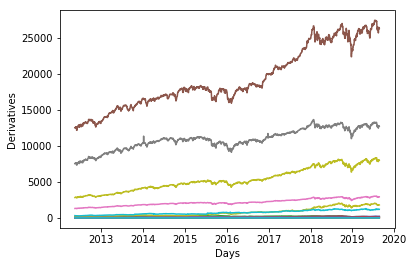

2019-08-23 00:00:00
FB    183.130005
Name: 2019-08-23 00:00:00, dtype: float64


(2654, 20)

In [7]:
dataset = dataset_csv.copy()
#dataset[[main_ticker + '_y']] = delta_time_ratios_df(dataset[[main_ticker + '_y']])
dataset, ticker_y = extract_column(dataset, main_ticker + '_y')

dataset, business_days = extract_column(dataset, 'Business_days')
#dataset = delta_time_series_df(dataset)

yesterday_date = dataset.index[-1]
yesterday_score = dataset.iloc[-1,dataset.columns == main_ticker]
dataset['Business_days'] = business_days
plot_dataset(dataset)
print(yesterday_date)
print(yesterday_score)
dataset.shape

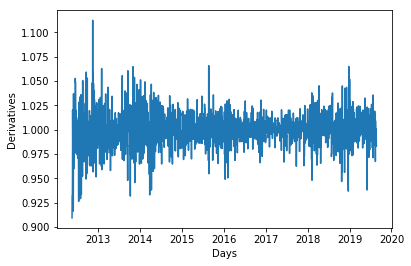

2654

In [8]:
plot_dataset(ticker_y)
ticker_y.size

In [9]:
# Ground truth.
dataset['y'] = (ticker_y > (1.0 + (gain / 2.0))).astype(int)
print('Percentage of ones (keep less than 5%):', 
      count_nonzero(dataset.y) / ticker_y.size)

Percentage of ones (keep less than 5%): 0.03127354935945742


In [10]:
print('Before shifting.')
dataset

Before shifting.


,FB,GE,ADS,INTC,AAPL,NVDA,CSCO,AMD,AMZN,GOOG,MSFT,S,BAC,XLNX,WFC,^DJI,^GSPC,^NYA,^IXIC,Business_days,y
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-18,45.000000,18.423077,123.690002,26.570000,77.629997,12.740000,16.639999,6.290000,219.630005,315.029205,29.809999,2.44,7.030000,32.119999,31.580000,12492.969727,1312.239990,7521.120117,2827.280029,1,0
2012-05-19,36.660000,18.451923,122.540001,26.190001,80.220001,12.350000,16.700001,6.340000,219.979996,306.695435,29.790001,2.39,7.110000,32.119999,31.469999,12508.110352,1316.390015,7543.609863,2848.830078,0,0
2012-05-20,36.660000,18.451923,122.540001,26.190001,80.220001,12.350000,16.700001,6.340000,219.979996,306.695435,29.790001,2.39,7.110000,32.119999,31.469999,12508.110352,1316.390015,7543.609863,2848.830078,0,0
2012-05-21,36.660000,18.451923,122.540001,26.190001,80.220001,12.350000,16.700001,6.340000,219.979996,306.695435,29.790001,2.39,7.110000,32.119999,31.469999,12508.110352,1316.390015,7543.609863,2848.830078,1,0
2012-05-22,33.590000,18.548077,124.010002,26.280001,81.982857,12.300000,16.820000,6.270000,218.869995,305.758942,29.879999,2.46,7.150000,32.049999,32.450001,12575.959961,1328.489990,7616.520020,2867.340088,1,0
2012-05-23,32.500000,18.471153,124.300003,25.510000,81.828575,12.460000,16.760000,6.080000,217.550003,303.661804,29.400000,2.49,7.170000,32.130001,31.799999,12508.299805,1320.709961,7547.060059,2855.350098,1,0
2012-05-24,33.209999,18.644230,126.449997,25.780001,82.357140,12.530000,16.700001,6.100000,217.660004,304.817474,29.299999,2.53,7.330000,32.090000,31.879999,12539.589844,1324.140015,7573.430176,2858.239990,1,0
2012-05-25,32.950001,18.673077,127.430000,25.850000,80.835716,12.500000,16.559999,6.220000,215.979996,299.741486,29.360001,2.65,7.250000,32.259998,32.150002,12533.120117,1324.199951,7567.359863,2846.310059,1,0
2012-05-26,31.690001,18.682692,129.470001,26.320000,82.000000,12.800000,16.639999,6.460000,216.550003,298.446350,29.719999,2.67,7.450000,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,0,0


In [11]:
print('After shifting.')
dataset = curve_shift(dataset, shift_by=-1)
dataset

After shifting.


,FB,GE,ADS,INTC,AAPL,NVDA,CSCO,AMD,AMZN,GOOG,MSFT,S,BAC,XLNX,WFC,^DJI,^GSPC,^NYA,^IXIC,Business_days,y
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-18,45.000000,18.423077,123.690002,26.570000,77.629997,12.740000,16.639999,6.290000,219.630005,315.029205,29.809999,2.44,7.030000,32.119999,31.580000,12492.969727,1312.239990,7521.120117,2827.280029,1,0
2012-05-19,36.660000,18.451923,122.540001,26.190001,80.220001,12.350000,16.700001,6.340000,219.979996,306.695435,29.790001,2.39,7.110000,32.119999,31.469999,12508.110352,1316.390015,7543.609863,2848.830078,0,0
2012-05-20,36.660000,18.451923,122.540001,26.190001,80.220001,12.350000,16.700001,6.340000,219.979996,306.695435,29.790001,2.39,7.110000,32.119999,31.469999,12508.110352,1316.390015,7543.609863,2848.830078,0,0
2012-05-21,36.660000,18.451923,122.540001,26.190001,80.220001,12.350000,16.700001,6.340000,219.979996,306.695435,29.790001,2.39,7.110000,32.119999,31.469999,12508.110352,1316.390015,7543.609863,2848.830078,1,0
2012-05-22,33.590000,18.548077,124.010002,26.280001,81.982857,12.300000,16.820000,6.270000,218.869995,305.758942,29.879999,2.46,7.150000,32.049999,32.450001,12575.959961,1328.489990,7616.520020,2867.340088,1,0
2012-05-23,32.500000,18.471153,124.300003,25.510000,81.828575,12.460000,16.760000,6.080000,217.550003,303.661804,29.400000,2.49,7.170000,32.130001,31.799999,12508.299805,1320.709961,7547.060059,2855.350098,1,0
2012-05-24,33.209999,18.644230,126.449997,25.780001,82.357140,12.530000,16.700001,6.100000,217.660004,304.817474,29.299999,2.53,7.330000,32.090000,31.879999,12539.589844,1324.140015,7573.430176,2858.239990,1,0
2012-05-25,32.950001,18.673077,127.430000,25.850000,80.835716,12.500000,16.559999,6.220000,215.979996,299.741486,29.360001,2.65,7.250000,32.259998,32.150002,12533.120117,1324.199951,7567.359863,2846.310059,1,0
2012-05-26,31.690001,18.682692,129.470001,26.320000,82.000000,12.800000,16.639999,6.460000,216.550003,298.446350,29.719999,2.67,7.450000,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,0,0


In [0]:
# Converts the DataFrame to a numpy array.
input_X, input_y = extract_column(dataset, 'y')
input_X = input_X.values
input_y = input_y.values

# Number of features.
n_features = input_X.shape[1]

In [13]:
# Test: The 3D tensors (arrays) for LSTM are forming correctly.
print('First instance of y = 1 in the original data.')
display(dataset.iloc[(where(array(input_y) == 1)[0][0] - lookback):(where(array(input_y) == 1)[0][0] + 1),])

# Temporalize the data.
X, y = temporalize(X=input_X, y=input_y, lookback=lookback)

print('For the same instance of y=1, we are keeping past 5 samples in the 3D predictor array, X.')
display(DataFrame(concatenate(X[where(array(y) == 1)[0][0]], axis=0)))

First instance of y = 1 in the original data.


,FB,GE,ADS,INTC,AAPL,NVDA,CSCO,AMD,AMZN,GOOG,MSFT,S,BAC,XLNX,WFC,^DJI,^GSPC,^NYA,^IXIC,Business_days,y
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-25,32.950001,18.673077,127.430000,25.850000,80.835716,12.50,16.559999,6.22,215.979996,299.741486,29.360001,2.65,7.25,32.259998,32.150002,12533.120117,1324.199951,7567.359863,2846.310059,1,0
2012-05-26,31.690001,18.682692,129.470001,26.320000,82.000000,12.80,16.639999,6.46,216.550003,298.446350,29.719999,2.67,7.45,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,0,0
2012-05-27,31.690001,18.682692,129.470001,26.320000,82.000000,12.80,16.639999,6.46,216.550003,298.446350,29.719999,2.67,7.45,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,0,0
2012-05-28,31.690001,18.682692,129.470001,26.320000,82.000000,12.80,16.639999,6.46,216.550003,298.446350,29.719999,2.67,7.45,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,0,0
2012-05-29,31.690001,18.682692,129.470001,26.320000,82.000000,12.80,16.639999,6.46,216.550003,298.446350,29.719999,2.67,7.45,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,1,0
2012-05-30,29.549999,18.461538,127.849998,26.190001,82.855713,12.67,16.480000,6.39,212.979996,294.844849,29.480000,2.66,7.41,32.400002,32.040001,12579.099609,1331.250000,7543.359863,2847.270020,1,1


For the same instance of y=1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,31.690001,18.682692,129.470001,26.320000,82.000000,12.80,16.639999,6.46,216.550003,298.446350,29.719999,2.67,7.45,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,0.0
1,31.690001,18.682692,129.470001,26.320000,82.000000,12.80,16.639999,6.46,216.550003,298.446350,29.719999,2.67,7.45,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,0.0
2,31.690001,18.682692,129.470001,26.320000,82.000000,12.80,16.639999,6.46,216.550003,298.446350,29.719999,2.67,7.45,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,0.0
3,31.690001,18.682692,129.470001,26.320000,82.000000,12.80,16.639999,6.46,216.550003,298.446350,29.719999,2.67,7.45,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,1.0
4,29.549999,18.461538,127.849998,26.190001,82.855713,12.67,16.480000,6.39,212.979996,294.844849,29.480000,2.66,7.41,32.400002,32.040001,12579.099609,1331.250000,7543.359863,2847.270020,1.0


The two tables are the same. This testifies that we are correctly taking 5 samples (= lookback), X(t):X(t-5) to predict y(t).

In [0]:
X_train, X_test, y_train, y_test = train_test_split(array(X), array(y), test_size=test_size, random_state=random_seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=random_seed)

In [0]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]
X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [16]:
X_train.shape

(1641, 5, 1, 20)

In [17]:
X_train_y0.shape

(1600, 5, 1, 20)

In [0]:
# (sample, channel, lookback, feature) -> (sample, lookback, feature).
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)

X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [0]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [20]:
# Test scaling validity.
a = flatten(X_train_y0_scaled)
print('Column-wise mean (should be all zeros):', mean(a, axis=0).round(6))
print('Column-wise variance (should be all ones):', var(a, axis=0))

Column-wise mean (should be all zeros): [-0. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0. -0.  0.  0. -0.  0.
 -0.  0.]
Column-wise variance (should be all ones): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
# Scale test and validation sets.
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)
X_test_scaled = scale(X_test, scaler)

In [0]:
_, timesteps, n_features = X_train_y0_scaled.shape

In [23]:
LSTM_autoencoder = Sequential()

# Encoder.
LSTM_autoencoder.add(LSTM(units=32, 
                          activation='relu', 
                          input_shape=(timesteps, n_features), 
                          return_sequences=True))

LSTM_autoencoder.add(LSTM(units=16, activation='relu', return_sequences=False))
LSTM_autoencoder.add(RepeatVector(timesteps))

# Decoder.
LSTM_autoencoder.add(LSTM(units=16, activation='relu', return_sequences=True))
LSTM_autoencoder.add(LSTM(units=32, activation='relu', return_sequences=True))
LSTM_autoencoder.add(TimeDistributed(Dense(n_features)))

# Keep parameters less than non-droped out features.
LSTM_autoencoder.summary()

W0825 19:10:25.506012 140488410724224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 19:10:25.509770 140488410724224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 19:10:25.521338 140488410724224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 32)             6784      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 20)             660       
Total params: 18,964
Trainable params: 18,964
Non-trainable params: 0
_________________________________________________________________


In [24]:
# LSTM autoencoder model for rare stock event prediction.
# Path to model weights (saved periodically).
filepath = path + 'LSTM_autoencoder.h5'
if exists(filepath):
    LSTM_autoencoder = load_model(filepath)
else:
    # Gradient descent optimization.
    optimizer = Adam(lr=learning_rate, clipnorm=1., clipvalue=0.5)

    # Training configuration.
    LSTM_autoencoder.compile(loss='mean_squared_error', optimizer=optimizer)

    # Save model weights after each epoch if validation loss decreased.
    checkpointer = ModelCheckpoint(filepath=filepath, 
                                   save_best_only=True, 
                                   verbose=1)

    # Control learning rate schedule when validation is not improving.
    reduce_lr = ReduceLROnPlateau(factor=0.1, 
                                  patience=epochs // 25, 
                                  verbose=1, 
                                  min_lr=learning_rate / 1000)

    # Various graphics.
    tbc = TensorBoardColab()

    # Shouldn't happen.
    term_on_NaN = TerminateOnNaN()

    history = LSTM_autoencoder.fit(X_train_y0_scaled, 
                                   X_train_y0_scaled, 
                                   epochs=epochs, 
                                   batch_size=batch_size, 
                                   validation_data=(X_valid_y0_scaled, 
                                                    X_valid_y0_scaled), 
                                   callbacks=[checkpointer, 
                                              reduce_lr, 
                                              TensorBoardColabCallback(tbc), 
                                              term_on_NaN], 
                                              verbose=1).history

W0825 19:10:26.402066 140488410724224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Wait for 8 seconds...
TensorBoard link:
http://73b55ed4.ngrok.io


W0825 19:10:43.952542 140488410724224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0825 19:10:46.400145 140488410724224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0825 19:10:46.569151 140488410724224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0825 19:10:46.751286 140488410724224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter i

Train on 1600 samples, validate on 407 samples


W0825 19:10:47.262452 140488410724224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Epoch 1/200
1600/1600 [==============================] - 3s 2ms/step - loss: 1.0001 - val_loss: 1.0593

Epoch 00001: val_loss improved from inf to 1.05931, saving model to /content/gdrive/My Drive/LSTM_autoencoder/LSTM_autoencoder.h5
Epoch 2/200
1600/1600 [==============================] - 0s 248us/step - loss: 0.9994 - val_loss: 1.0582

Epoch 00002: val_loss improved from 1.05931 to 1.05824, saving model to /content/gdrive/My Drive/LSTM_autoencoder/LSTM_autoencoder.h5
Epoch 3/200
1600/1600 [==============================] - 0s 248us/step - loss: 0.9982 - val_loss: 1.0565

Epoch 00003: val_loss improved from 1.05824 to 1.05650, saving model to /content/gdrive/My Drive/LSTM_autoencoder/LSTM_autoencoder.h5
Epoch 4/200
1600/1600 [==============================] - 0s 286us/step - loss: 0.9961 - val_loss: 1.0534

Epoch 00004: val_loss improved from 1.05650 to 1.05336, saving model to /content/gdrive/My Drive/LSTM_autoencoder/LSTM_autoencoder.h5
Epoch 5/200
1600/1600 [=======================

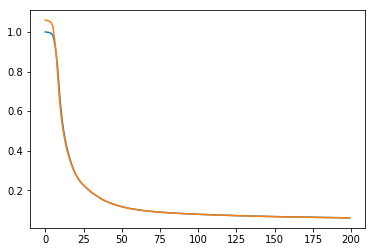

In [25]:
# Print training and test loss histories.
try:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])

# Skip because model was probably loaded from file.
except:
    pass

Reconstruction error should be less than one.


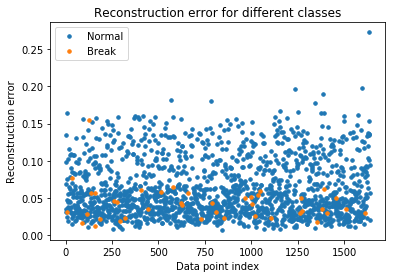

In [26]:
print('Reconstruction error should be less than one.')

train_x_predictions = LSTM_autoencoder.predict(X_train_scaled)
mse = mean(power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), 
           axis=1)

error = DataFrame({'Reconstruction_error': mse, 'True_class': y_train.tolist()})

groups = error.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, 
            group.Reconstruction_error, 
            marker='o', 
            ms=3.5, 
            linestyle='',
            label = 'Break' if name == 1 else 'Normal')

ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()

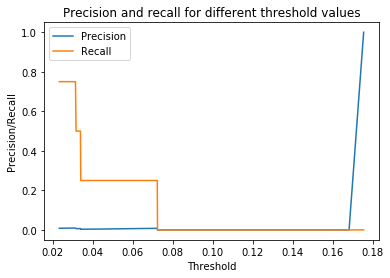

In [27]:
# Predictions on validation data.
valid_x_predictions = LSTM_autoencoder.predict(X_valid_scaled)
mse = mean(power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), 
           axis=1)

error = DataFrame({'Reconstruction_error': mse, 'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error.True_class, 
                                                               error.Reconstruction_error)

plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

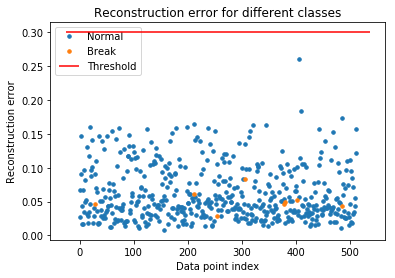

In [28]:
# Predictions on testing data.
test_x_predictions = LSTM_autoencoder.predict(X_test_scaled)
mse = mean(power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), 
           axis=1)

error = DataFrame({'Reconstruction_error': mse, 'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, 
            group.Reconstruction_error, 
            marker='o', 
            ms=3.5, 
            linestyle='',
            label= 'Break' if name == 1 else 'Normal')

ax.hlines(threshold_fixed, 
          ax.get_xlim()[0], 
          ax.get_xlim()[1], 
          colors='r', 
          zorder=100, 
          label='Threshold')

ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()

In [0]:
pred_y = [1 if e > threshold_fixed else 0 for e in error.Reconstruction_error.values]
conf_matrix = confusion_matrix(error.True_class, pred_y)

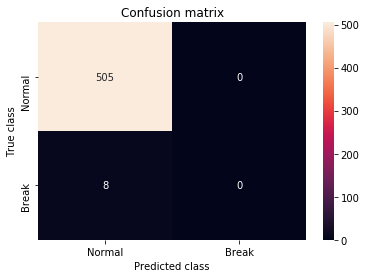

In [30]:
heatmap(conf_matrix, 
        xticklabels=labels, 
        yticklabels=labels, 
        annot=True, 
        fmt='d')

plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error.True_class, 
                                                      error.Reconstruction_error)

roc_auc = auc(false_pos_rate, true_pos_rate)

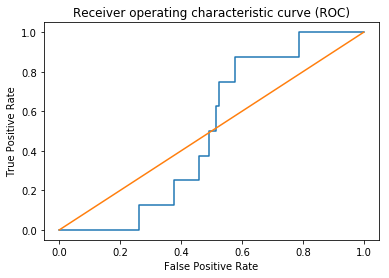

AUC = 0.5


In [32]:
plt.plot(false_pos_rate, true_pos_rate)
plt.plot([0, 1], [0, 1])

plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC = ' + str(round(roc_auc, 3)))